In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
import os

import torch
from torch import nn, optim 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [47]:
class Dataset_2D(Dataset):
    
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        
        self.ds = ds
        self.var_dict = var_dict
        #self.batch_size = batch_size
        #self.shuffle = shuffle
        self.lead_time = lead_time
        self.lat = len(ds['lat'])
        self.lon = len(ds['lon'])
        self.features = len(var_dict)
    
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        
        # Normalize
        self.data = (self.data - self.mean) / self.std
        
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.idxs = np.arange(self.n_samples)
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time
        
        if load: print('Loading data into RAM'); self.data.load()
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        idxs = self.idxs[idx]
        X = torch.Tensor(self.data.isel(time=idx).values).view((self.features, self.lat, self.lon))
        y = torch.Tensor(self.data.isel(time=idx + self.lead_time).values).view((self.features, 
                                                                                  self.lat, self.lon))

        return X, y
    
def load_test_data(path, var, years=slice('2017', '2018')):
    """
    Args:
        path: Path to nc files
        var: variable. Geopotential = 'z', Temperature = 't'
        years: slice for time window
    Returns:
        dataset: Concatenated dataset for 2017 and 2018
    """
    assert var in ['z', 't'], 'Test data only for Z500 and T850'
    ds = xr.open_mfdataset(f'{path}/*.nc', combine='by_coords')[var]
    try:
        ds = ds.sel(level=500 if var == 'z' else 850).drop('level')
    except ValueError:
        pass
    return ds.sel(time=years)

In [3]:
class PeriodicConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.pad_width = int((self.kernel_size - 1)/2)
        
        self.conv = nn.Conv2d(in_channels, out_channels, self.kernel_size, padding=0)
        
        nn.init.xavier_uniform_(self.conv.weight)
        nn.init.zeros_(self.conv.bias)
    
    def pad(self, x):
        padded = torch.cat((x[:, :, :, -self.pad_width:], x, x[:, :, :, :self.pad_width]), dim=3)
        padded = F.pad(padded, (0, 0, self.pad_width, self.pad_width), 'constant', 0)
        
        return padded
    
    def forward(self, x):
        padded = self.pad(x)
        output = self.conv(padded)
        
        return output

In [4]:
class PeriodicCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        
        super().__init__()
        
        self.conv1 = PeriodicConv2D(in_channels, 64, kernel_size)
        self.conv2 = PeriodicConv2D(64, 64, kernel_size)
        self.conv3 = PeriodicConv2D(64, 64, kernel_size)
        self.conv4 = PeriodicConv2D(64, 64, kernel_size)
        self.conv5 = PeriodicConv2D(64, out_channels, kernel_size)
        
    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input to be forwarded.
        Returns:
            :obj:`torch.Tensor`: output
        """
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = self.conv5(x)
        
        return x

In [45]:
def create_predictions(model, dg, mean, std):
    """Create non-iterative predictions"""
    
    outputs = []
    for i, (sample, _) in enumerate(dg):
        sample = sample.to(device)
        output = model(sample).detach().cpu().clone().numpy().reshape((-1, 32, 64, 2))
        outputs.append(output)
    preds = np.concatenate(outputs)
    
    # Unnormalize
    preds = preds * std.values + mean.values
    das = []
    lev_idx = 0
    for var, levels in dg.dataset.var_dict.items():
        if levels is None:
            das.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.dataset.valid_time, 'lat': dg.dataset.data.lat, 'lon': dg.dataset.data.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.dataset.valid_time, 'lat': dg.dataset.data.lat, 'lon': dg.dataset.data.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(das)

def compute_weighted_rmse(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    Compute the RMSE with latitude weighting from two xr.DataArrays.
    Args:
        da_fc (xr.DataArray): Forecast. Time coordinate must be validation time.
        da_true (xr.DataArray): Truth.
    Returns:
        rmse: Latitude weighted root mean squared error
    """
    error = da_fc - da_true
    weights_lat = np.cos(np.deg2rad(error.lat))
    weights_lat /= weights_lat.mean()
    rmse = np.sqrt(((error)**2 * weights_lat).mean(mean_dims))
    if type(rmse) is xr.Dataset:
        rmse = rmse.rename({v: v + '_rmse' for v in rmse})
    else: # DataArray
        rmse.name = error.name + '_rmse' if not error.name is None else 'rmse'
    return rmse

In [117]:
import math
import torch
from torch.optim import Optimizer


class myAdam(Optimizer):
    r"""Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-7,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(myAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(myAdam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data) #, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data) #, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data) #, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt()).add_(group['eps'])

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [111]:
def train_model(model, device, train_generator, epochs, lr, validation_data, patience):
    
    criterion = nn.MSELoss()
    beta2 = 0.999
    epsilon = 1e-7#/(np.sqrt(1-beta2))
    optimizer = myAdam(model.parameters(), lr=lr, eps=epsilon, weight_decay=0, amsgrad=False)
    
    min_val_loss = float("inf")
    epoch_no_improve = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()
        for batch_idx, (batch, labels) in enumerate(train_generator):
            # Transfer to GPU
            batch, labels = batch.to(device), labels.to(device)
            
            batch_size = batch.shape[0]
            
            # Model
            output = model(batch)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
        train_loss = train_loss / (len(train_generator.dataset))
        train_losses.append(train_loss)
        
        model.eval()
        with torch.set_grad_enabled(False):
            for batch, labels in validation_data:
                # Transfer to GPU
                batch, labels = batch.to(device), labels.to(device)
                
                batch_size = batch.shape[0]
                
                output = model(batch)

                val_loss = val_loss + criterion(output, labels).item() * batch_size
                
        val_loss = val_loss / (len(validation_data.dataset))
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
                
        # Check for early stopping
        if val_loss < min_val_loss:
            epoch_no_improve = 0
            min_val_loss = val_loss
        else:
            epoch_no_improve += 1

        if epoch_no_improve == patience:
            print('Epoch {e:3d}: early stopping'.format(e=epoch+1))
            return train_losses, val_losses
        
    return train_losses, val_losses

In [7]:
def main(datadir, model_save_fn, pred_save_fn, vars, kernel_size, lead_time, lr=1e-4, activation='elu', dr=0, 
         batch_size=128, patience=3, train_years=('1979', '2015'), valid_years=('2016', '2016'), 
         test_years=('2017', '2018'), gpu=1, iterative=False):

    # 1. Open dataset and create data generators
    z = xr.open_mfdataset(f'{datadir}geopotential_500/*.nc', combine='by_coords')
    t = xr.open_mfdataset(f'{datadir}temperature_850/*.nc', combine='by_coords')
    ds = xr.merge([z, t], compat='override')  # Override level. discarded later anyway.

    ds_train = ds.sel(time=slice(*train_years))
    ds_valid = ds.sel(time=slice(*valid_years))
    ds_test = ds.sel(time=slice(*test_years))

    dic = {var: None for var in vars}
    
    ################## FROM NOW ON THIS IS NOT THE SAME #############
    
    dataset_train = Dataset_2D(ds_train, dic, lead_time)
    dataset_valid = Dataset_2D(ds_valid, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)
    dataset_test = Dataset_2D(ds_test, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)
    
    dg_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
    dg_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=1)
    dg_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)
    

    # 2. Build model and put on GPU
    model = PeriodicCNN(in_channels=2, out_channels=2, kernel_size=kernel_size)
    if torch.cuda.is_available():
        if gpu is None:
            device = torch.device("cuda")
            model = model.to(device)
            model = nn.DataParallel(model)
        else:
            device = torch.device("cuda:{}".format(gpu))
            model = model.to(device)


    # 3. Train model
    train_loss, val_loss = train_model(model, device, dg_train, epochs=100, lr=lr, 
                                       validation_data=dg_valid, patience=patience)

    print(f'Saving model weights: {model_save_fn}')
    torch.save(model.state_dict(), model_save_fn)

   # Create predictions
    pred = create_predictions(model, dg_test, mean=dataset_train.mean, std=dataset_train.std)
    print(f'Saving predictions: {pred_save_fn}')
    pred.to_netcdf(pred_save_fn)

    # Print score in real units
    z500_valid = load_test_data(f'{datadir}geopotential_500', 'z')
    t850_valid = load_test_data(f'{datadir}temperature_850', 't')
    valid = xr.merge([z500_valid, t850_valid], compat='override')
    print(evaluate_iterative_forecast(pred, valid).load() if iterative else 
          compute_weighted_rmse(pred, valid).load())
    
    return train_loss, val_loss

In [8]:
datadir = "/mnt/scratch/students/illorens/data/5.625deg/"

lr=1e-4
activation='elu'
dr=0
batch_size=128
patience=3
train_years=('1979', '2015')
valid_years=('2016', '2016')
test_years=('2017', '2018')
gpu=1
iterative=False

vars = ['z', 't']
kernel_size = 5

## 3 day prediction

In [9]:
model_save_fn = "/mnt/scratch/students/illorens/data/predictions/models/torch_fccnn_3d.h5"
pred_save_fn = "/mnt/scratch/students/illorens/data/predictions/torch_fccnn_3d.nc"
lead_time = 72

In [10]:
# 1. Open dataset and create data generators
z = xr.open_mfdataset(f'{datadir}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{datadir}temperature_850/*.nc', combine='by_coords')
ds = xr.merge([z, t], compat='override')  # Override level. discarded later anyway.

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*valid_years))
ds_test = ds.sel(time=slice(*test_years))

dic = {var: None for var in vars}

### FROM NOW ON THIS IS NOT THE SAME 

In [11]:
dataset_train = Dataset_2D(ds_train, dic, lead_time)
dataset_valid = Dataset_2D(ds_valid, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)
dataset_test = Dataset_2D(ds_test, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)

Loading data into RAM
Loading data into RAM
Loading data into RAM


In [12]:
dg_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
dg_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=1)
dg_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

In [14]:
# 2. Build model and put on GPU
model = PeriodicCNN(in_channels=2, out_channels=2, kernel_size=kernel_size)
if torch.cuda.is_available():
    if gpu is None:
        device = torch.device("cuda")
        model = model.to(device)
        model = nn.DataParallel(model)
    else:
        device = torch.device("cuda:{}".format(gpu))
        model = model.to(device)

In [118]:
# 3. Train model
train_loss, val_loss = train_model(model, device, dg_train, epochs=100, lr=lr, 
                                   validation_data=dg_valid, patience=patience)

print(f'Saving model weights: {model_save_fn}')
torch.save(model.state_dict(), model_save_fn)

Epoch:   1/100  - loss: 0.420  - val_loss: 0.45924  - time: 440.947056
Epoch:   2/100  - loss: 0.419  - val_loss: 0.45808  - time: 418.733010
Epoch:   3/100  - loss: 0.419  - val_loss: 0.45883  - time: 402.845594
Epoch:   4/100  - loss: 0.418  - val_loss: 0.46097  - time: 413.816336
Epoch:   5/100  - loss: 0.418  - val_loss: 0.46014  - time: 433.962185
Epoch   5: early stopping
Saving model weights: /mnt/scratch/students/illorens/data/predictions/models/torch_fccnn_3d.h5


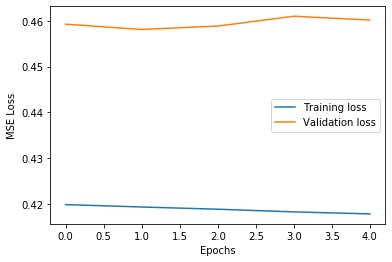

In [119]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [120]:
# Create predictions
pred = create_predictions(model, dg_test, mean=dataset_train.mean, std=dataset_train.std)
print(f'Saving predictions: {pred_save_fn}')
pred.to_netcdf(pred_save_fn)

# Print score in real units
z500_valid = load_test_data(f'{datadir}geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid], compat='override')
print(evaluate_iterative_forecast(pred, valid).load() if iterative else compute_weighted_rmse(pred, valid).load())

Saving predictions: /mnt/scratch/students/illorens/data/predictions/torch_fccnn_3d.nc
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z_rmse   float64 702.4
    t_rmse   float64 3.153


## 5 day prediction

In [ ]:
model_save_fn_5d = "/mnt/scratch/students/illorens/data/predictions/models/torch_fccnn_5d.h5"
pred_save_fn_5d = "/mnt/scratch/students/illorens/data/predictions/torch_fccnn_5d.nc"
lead_time_5d = 120

In [ ]:
train_loss_5d, val_loss_5d = main(datadir, model_save_fn_5d, pred_save_fn_5d, vars, kernel_size, lead_time_5d)

In [ ]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()